Using device: cuda
Training samples: 6542
Validation samples: 369

Training Region ID distribution:
Region_ID
1     362
2     450
3     444
4     461
5     484
6     452
7     394
8     503
9     262
10    546
11    403
12    445
13    397
14    166
15    773
Name: count, dtype: int64


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:06<00:00, 57.3MB/s]


Epoch 1/40:
Train Loss: 2.1899, Train Acc: 0.3202
Val Loss: 1.5974, Val Acc: 0.4743

Validation loss decreased (inf --> 1.597391). Saving model...
Epoch 2/40:
Train Loss: 1.4015, Train Acc: 0.5997
Val Loss: 1.1786, Val Acc: 0.6070

Validation loss decreased (1.597391 --> 1.178648). Saving model...
Epoch 3/40:
Train Loss: 1.0020, Train Acc: 0.7174
Val Loss: 0.8388, Val Acc: 0.7371

Validation loss decreased (1.178648 --> 0.838823). Saving model...
Epoch 4/40:
Train Loss: 0.7500, Train Acc: 0.7866
Val Loss: 0.6309, Val Acc: 0.8266

Validation loss decreased (0.838823 --> 0.630866). Saving model...
Epoch 5/40:
Train Loss: 0.5796, Train Acc: 0.8345
Val Loss: 0.4662, Val Acc: 0.8564

Validation loss decreased (0.630866 --> 0.466163). Saving model...
Epoch 6/40:
Train Loss: 0.4583, Train Acc: 0.8666
Val Loss: 0.4273, Val Acc: 0.8645

Validation loss decreased (0.466163 --> 0.427350). Saving model...
Epoch 7/40:
Train Loss: 0.3768, Train Acc: 0.8933
Val Loss: 0.4476, Val Acc: 0.8482

EarlySto

/tmp/ipykernel_19/2005057218.py:228: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_convnext_model.pth'))


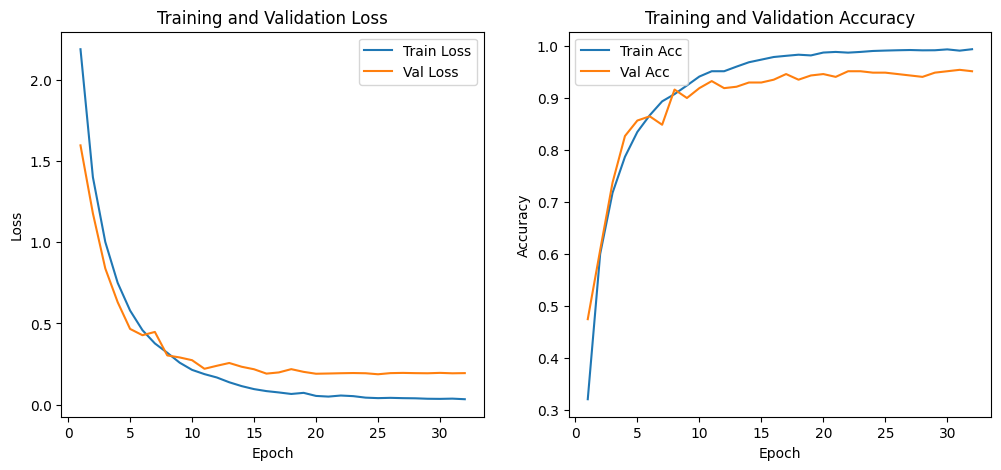

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
train_csv_path = '/kaggle/input/smai-s-25-section-a-project-phase-2/labels_train.csv'
val_csv_path = '/kaggle/input/smai-s-25-section-a-project-phase-2/labels_val.csv'
train_img_dir = '/kaggle/input/smai-s-25-section-a-project-phase-2/images_train/images_train'
val_img_dir = '/kaggle/input/smai-s-25-section-a-project-phase-2/images_val/images_val'

# Load data
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Check region distribution
print("\nTraining Region ID distribution:")
print(train_df['Region_ID'].value_counts().sort_index())

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),  # Sometimes valuable for region classification
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Keep validation transform simpler
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset class
class RegionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = csv_file
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            # Return a placeholder image in case of error
            image = Image.new('RGB', (256, 256), color='gray')
            
        if self.transform:
            image = self.transform(image)
            
        label = self.data_frame.iloc[idx, 5] - 1  # Convert 1-15 to 0-14 for PyTorch
        
        return image, label

# Create datasets with different transforms
train_dataset = RegionDataset(train_df, train_img_dir, transform)
val_dataset = RegionDataset(val_df, val_img_dir, transform_val)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load a pre-trained model
model = models.convnext_base(weights='IMAGENET1K_V1')

num_ftrs = model.classifier[2].in_features
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.Dropout(0.2),  # Add dropout before final classification layer
    nn.Linear(num_ftrs, 15)
)

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Define early stopping parameters
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True, path='best_model.pth'):
        """
        Args:
            patience (int): How many epochs to wait after validation loss improvement.
            min_delta (float): Minimum change in validation loss to qualify as improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        '''Save model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Training function with early stopping
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=7):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_convnext_model.pth')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = val_loss / len(val_dataset)
        val_losses.append(epoch_val_loss)
        
        val_acc = accuracy_score(all_labels, all_preds)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.4f}\n')
        
        # Adjust learning rate
        scheduler.step(epoch_val_loss)
        
        # Early stopping
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Load the best model
    model.load_state_dict(torch.load('best_convnext_model.pth'))
    
    return model, train_losses, val_losses, train_accs, val_accs

# Train the model
num_epochs = 40
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs, patience=7)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('training_metrics.png')

# Save the final model (the best model was already saved during training)
torch.save(model.state_dict(), 'convnext_region_classification_model_final.pth')
